<a href="https://colab.research.google.com/github/arpita0911/Customer-Churn-Analysis/blob/main/Customer_churn_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Predictive Analysis of Customer Churn for a Subscription Service**

##Importing Libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, f1_score
from joblib import dump
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

##Data Import and Export Using Pandas

In [3]:
from google.colab import files

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)

print("First 5 rows of the dataset:")
print(data.head())

print("\nNumber of rows and columns:")
print(data.shape)

print("\nColumn names and data types:")
print(data.dtypes)

print("\nMissing values in each column:")
print(data.isnull().sum())

print("\nStatistical summary of numerical columns:")
print(data.describe())


Saving Customer Churn new.csv to Customer Churn new (1).csv
First 5 rows of the dataset:
   RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0        747    15787619      Hsieh          844    France    Male   18   
1       1620    15770309   McDonald          656    France    Male   18   
2       1679    15569178  Kharlamov          570    France  Female   18   
3       2022    15795519   Vasiliev          716   Germany  Female   18   
4       2137    15621893   Bellucci          727    France    Male   18   

   Tenure    Balance  EstimatedSalary  Exited  
0       2  160980.03        145936.28       0  
1      10  151762.74        127014.32       0  
2       4   82767.42         71811.90       0  
3       3  128743.80        197322.13       0  
4       4  133550.67         46941.41       0  

Number of rows and columns:
(10000, 11)

Column names and data types:
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore         

##Exploratory Data Analysis (EDA)


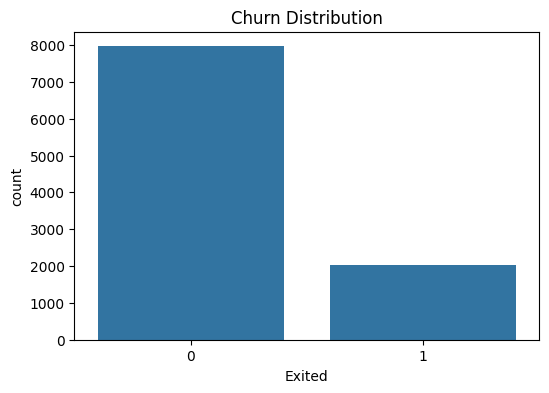

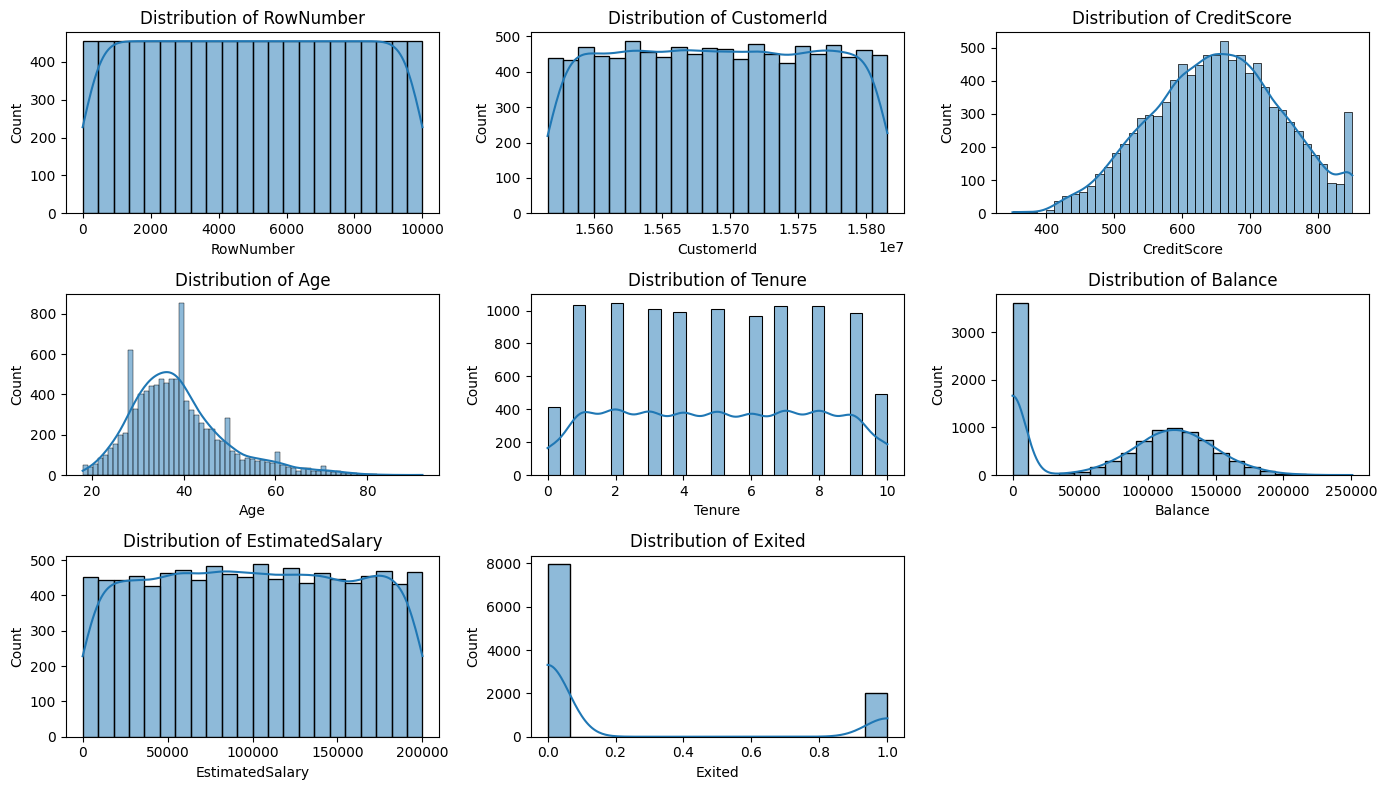

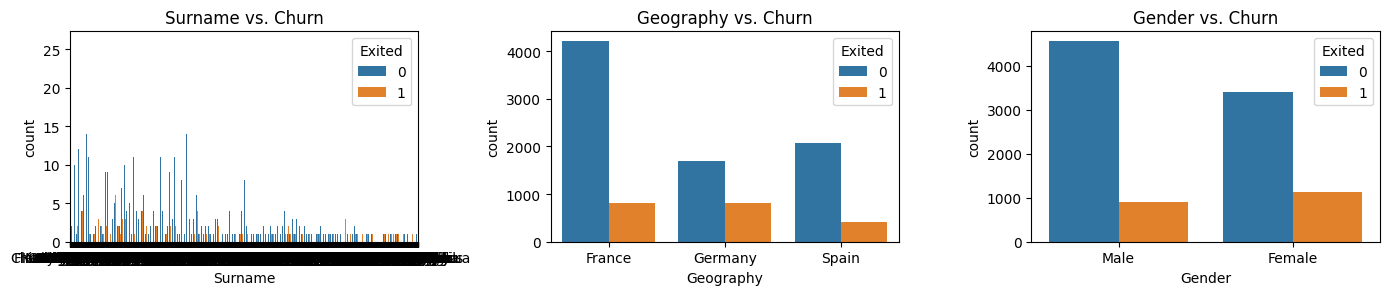

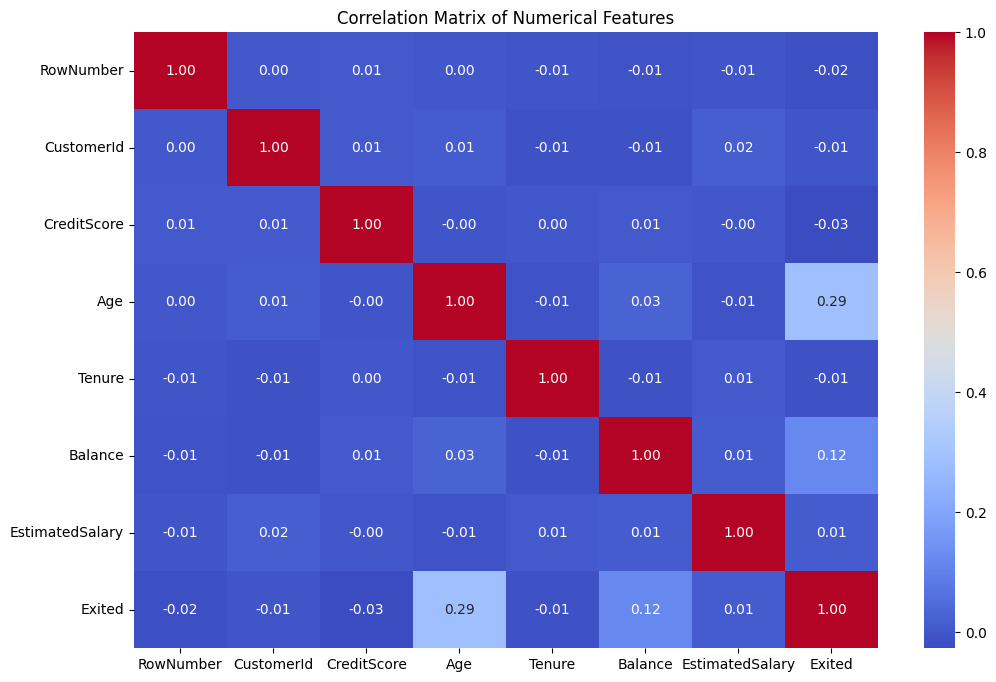

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='Exited')
plt.title('Churn Distribution')
plt.show()

numerical_cols = data.select_dtypes(include=np.number).columns
categorical_cols = data.select_dtypes(include='object').columns

plt.figure(figsize=(14, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=data, x=col, hue='Exited')
    plt.title(f'{col} vs. Churn')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,8))
sns.heatmap(data[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


##Handling Missing Values and Outliers

In [7]:
data = data.dropna()

for col in numerical_cols:
    q_low = data[col].quantile(0.01)
    q_high = data[col].quantile(0.99)
    data[col] = np.where(data[col] < q_low, q_low, data[col])
    data[col] = np.where(data[col] > q_high, q_high, data[col])

##Feature Engineering and Encoding

In [8]:
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

##Feature Scaling

In [9]:
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

##Dimensionality Reduction Using PCA:

In [10]:
pca = PCA(n_components=0.95)
X = data.drop('Exited', axis=1)
X_pca = pca.fit_transform(X)
y = data['Exited']

##Handling Imbalanced Data

In [14]:
y = (data['Exited'] > 0.5).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE - y_train:", y_train.value_counts())
print("After SMOTE - y_train_resampled:", y_train_resampled.value_counts())

Before SMOTE - y_train: Exited
0    6373
1    1627
Name: count, dtype: int64
After SMOTE - y_train_resampled: Exited
1    6373
0    6373
Name: count, dtype: int64


##Model Building and Data Visualization


Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1590
           1       0.31      0.27      0.29       410

    accuracy                           0.73      2000
   macro avg       0.56      0.56      0.56      2000
weighted avg       0.71      0.73      0.72      2000



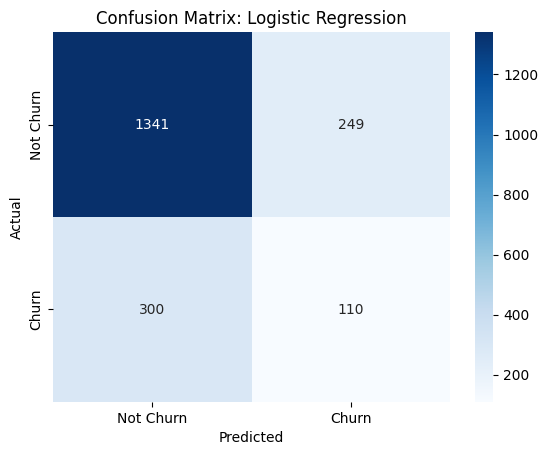

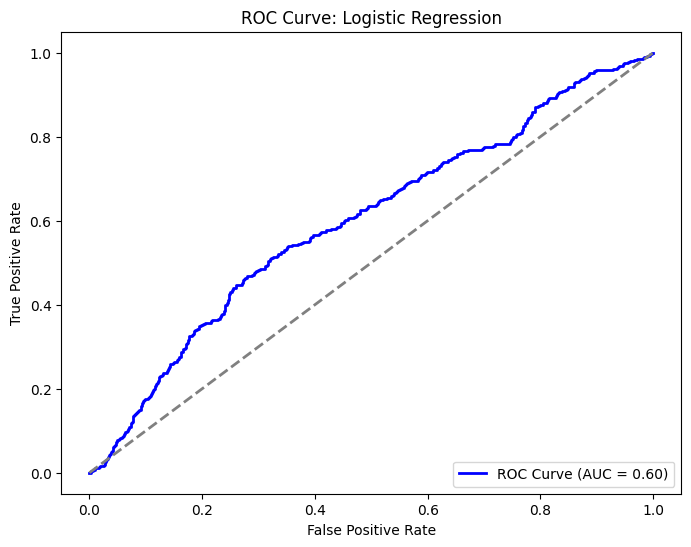

Model: Random Forest
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1590
           1       0.61      0.25      0.36       410

    accuracy                           0.81      2000
   macro avg       0.72      0.61      0.62      2000
weighted avg       0.79      0.81      0.78      2000



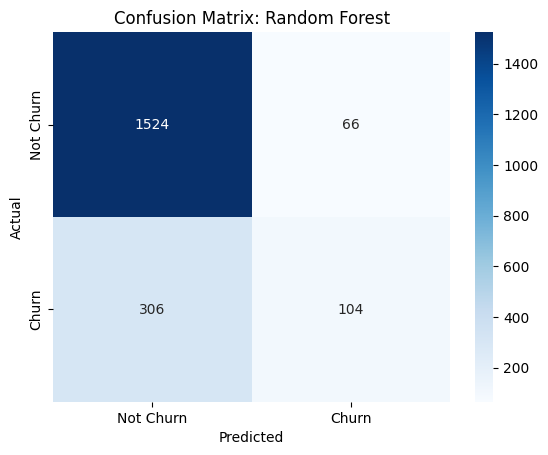

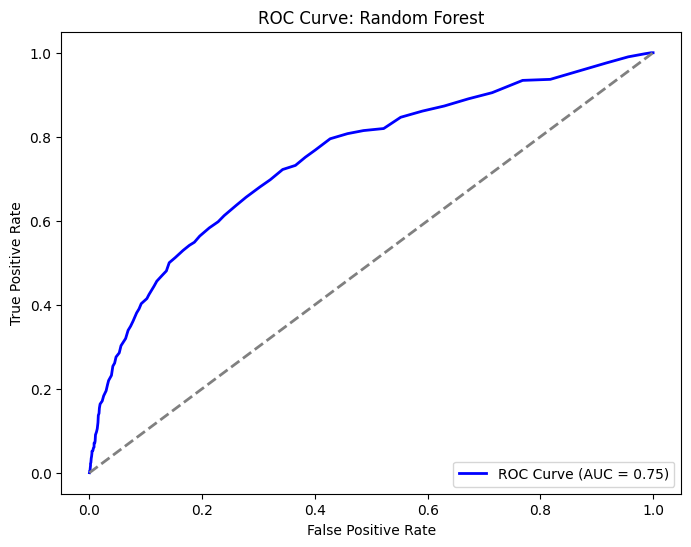

Model: Gradient Boosting
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1590
           1       0.57      0.34      0.43       410

    accuracy                           0.81      2000
   macro avg       0.71      0.64      0.66      2000
weighted avg       0.79      0.81      0.79      2000



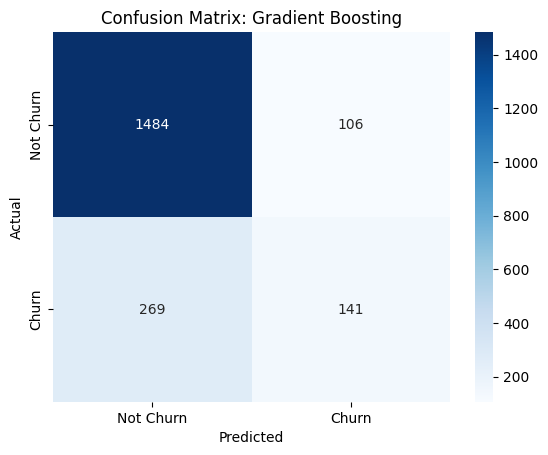

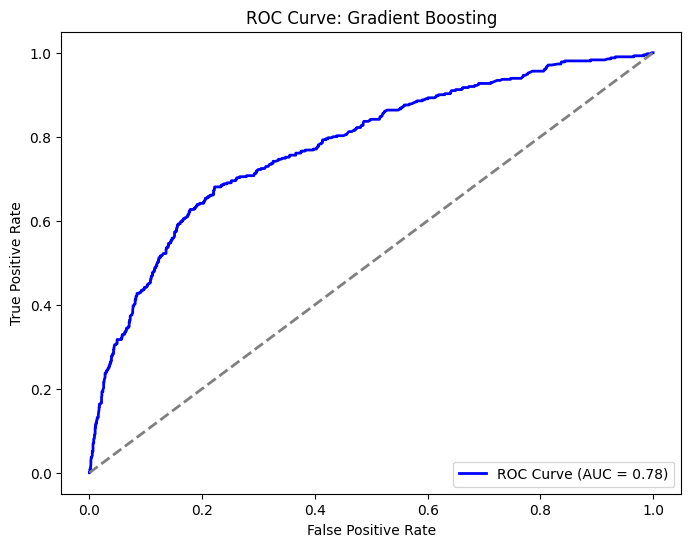

In [18]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

for model_name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)

    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc="lower right")
    plt.show()

##Documentation and Reporting

### **Data Sources:**

Obtained customer churn dataset from Kaggle.
Data includes information about the customer demographics and account. Also, it is mentioned whether the customer churned or not (Exited column).

### **Data Description:**

The following columns are present in the dataset:

RowNumber: Row identifier.

CustomerId: Unique identifier for every customer.

Surname: Customer's surname, which doesn't matter from modeling.

CreditScore: Credit score of the customer.

Geography: Country of residence of the customer. This is a categorical feature.

Gender: Gender of the customer. This is also a categorical feature.

Age: Age of the customer.

Tenure: The number of years the customer has been with the service.

Balance: The balance in the account.

EstimatedSalary: The estimated salary of the customer.

Exited: Target that indicates whether a customer has churned or not.
(i.e., 1 represents that a customer churned and 0 that it did not.)

###**Insights Obtained**

What Drives Churn:
The two variables that have a huge impact on churn are tenure (how long the customer has stayed with the service) and balance (account balance).
Older customers are more likely to churn with lesser tenures.
Having a good credit score and earning a higher salary correlates with a lower chance of churn.
Model Selection Rationale:

Logistic Regression: It's worth for simplicity and interpretability value that can clarify the relationship between the feature and churn likelihood.
Random Forest: It can tackle nonlinear relationships and is helpful for feature importance.
Gradient Boosting: This algorithm can create high-performance models as it works nicely on complicated situations involving relationships between the features involved.
Performance Metrics:

Accuracy: It is the count of instances where a classification model correctly predicts.
Precision and Recall: Precision is the proportion of true churn out of the predicted churn. Recall is the proportion of actual churn that came in the right prediction.
F1-Score: It is the harmonic mean of precision and recall for an average measure of performance.
AUC-ROC Curve: This is a method of determination at what percentage the model does better in discriminating between churn and non-churn customers.

###**Potential Use of the Model in Business Strategy:**

Targeted Retention Strategies: This model can be applied in identifying high-risk customers and targeting the right set of activities which businesses can offer to these customers, such as giving them a discount, offering customized offers, or enhancing customer service.
Customer Segmentation: It helps categorize customers according to the churn risk and tailor marketing or support efforts accordingly.

Operational Efficiency: It helps businesses prioritize all resources by concentrating on those customers who may turn out to be high-risk customers, in turn improving their customer retention efforts.

Conclusion: This customer churn prediction model carries a lot of utilities toward business. It enables the business to take proactive steps against churn in the customers. Models or other options may be added that are more complex or require incorporating further features, such as interactions or feedback on customer service and the like.

